In [1]:
import numpy as np
import pandas as pd
import os

In [11]:
# define a class including all parameter
class Para:
    method = 'SVM'
    month_in_sample = range(1,5 + 1) #return in-sample months
    month_test = range(6,12 + 1) #return test months
    percent_select = [0.3,0.3] # 30% positive samples, 30% NEGATIVE SAMPLES
    percent_cv = 0.1 #10% cross validation samples
    path_data = os.getcwd() + '\\data\\'
    path_results = os.getcwd() + '\\results_demo\\'
    seed = 2019
    svm_kernel = 'linear'
    svm_c = 0.01
    #n_stock=100
para = Para()

In [12]:
def label_data(data):
    data['return_bin'] = np.nan
    data = data.sort_values(by = 'return',ascending = False)
    # decide how much stocks will be selected
    n_stock_select = np.multiply(para.percent_select,data.shape[0])
    n_stock_select = np.around(n_stock_select).astype(int)
    data.iloc[0:n_stock_select[0],-1] = 1
    data.iloc[-n_stock_select[1]:,-1] = 0
    data = data.dropna(axis=0)
    return data


In [13]:
#generate in-sample data
for i_month in para.month_in_sample:
    file_name = para.path_data + str(i_month) + '.csv'
    data_curr_month = pd.read_csv(file_name, header=0)
    para.n_stock = data_curr_month.shape[0]

    data_curr_month = data_curr_month.dropna(axis=0)
    # label data
    data_curr_month = label_data(data_curr_month)
    if i_month == para.month_in_sample[0]: 
        data_in_sample = data_curr_month
    else:
        data_in_sample = data_in_sample.append(data_curr_month)


In [14]:
data_curr_month.head()

,Unnamed: 0,Unnamed: 0.1,month,label,return,beta,book_to_price_ratio,earnings_yield,growth,leverage,...,total_profit_to_cost_ratio,Kurtosis120,sharpe_ratio_120,Skewness120,Variance120,boll_down,EMA5,EMAC20,MFI14,return_bin
348,348,000809.XSHE,5,1,1.168435,0.597783,0.111358,0.384619,0.526726,0.051527,...,0.940523,0.035189,0.111385,0.180795,0.001306,0.880055,0.749303,0.644969,0.618516,1.0
2614,2614,600502.XSHG,5,1,0.901585,0.769131,0.491661,0.404751,0.590490,0.120079,...,0.940462,0.038149,0.129461,0.146409,0.001230,0.889427,0.839458,0.672536,0.530173,1.0
347,347,000807.XSHE,5,1,0.737083,0.858176,0.389019,0.485355,0.584782,0.114762,...,0.940071,0.030240,0.124322,0.174764,0.001524,0.923274,0.822530,0.698678,0.587298,1.0
2697,2697,600595.XSHG,5,1,0.714657,0.955104,0.414824,0.533449,0.571972,0.146377,...,0.940421,0.031007,0.122877,0.170187,0.001708,0.940005,0.807760,0.689468,0.508102,1.0
416,416,000908.XSHE,5,1,0.638967,0.883790,0.136091,0.324070,0.476348,0.139001,...,0.939083,0.028166,0.170417,0.159840,0.002270,0.789709,0.680798,0.587452,0.692439,1.0


In [15]:
# generate training and cv sets
X_in_sample = data_in_sample.loc[:, 'beta':'MFI14']
y_in_sample = data_in_sample.loc[:, 'return_bin']
from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv, random_state=para.seed)
# PCA
from sklearn import decomposition
pca = decomposition.PCA(n_components=0.95)
pca.fit(X_train)
X_train = pca.transform(X_train) 
X_cv = pca.transform(X_cv)

In [16]:
# preprocessing
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_cv = scaler.transform(X_cv)

In [17]:
# set model
if para.method == 'SVM':
    from sklearn import svm
    model = svm.SVC(kernel=para.svm_kernel, C=para.svm_c)

In [21]:
4409/5/0.3

2939.3333333333335

In [19]:
pd.DataFrame(X_train)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-1.046325,0.149608,-0.461629,-0.397561,-1.836984,-0.114842,1.188911,-0.876096,1.008841,-0.303844,...,2.036230,0.993295,-0.661169,1.156792,0.134351,0.342005,-0.479321,-0.420898,0.395618,-0.282883
1,1.000134,-1.109237,-1.235770,-0.998616,0.821079,-0.875192,-0.632480,0.146803,-0.701880,0.557452,...,-0.277405,-1.190565,-0.064440,-1.277894,0.249126,2.486807,0.513298,1.030835,0.529921,0.036537
2,0.954654,-0.533243,1.134652,-2.088924,0.413730,-0.603527,0.887964,-0.619913,0.075629,-0.358369,...,-0.503746,-1.128291,0.855551,-1.469271,-0.246687,-1.433483,0.826844,0.148175,0.029440,-0.165200
3,1.393910,0.356523,-0.429003,1.074268,-1.170022,0.073191,-1.137044,-0.553110,0.933808,0.088638,...,0.408250,1.316398,-0.430560,0.118301,0.461707,-0.440352,-0.014478,-0.128336,0.209991,-0.331455
4,-0.498859,1.483195,0.362053,-0.673114,0.458213,0.632357,0.258423,0.884384,-0.481897,0.595087,...,-0.870735,-0.936257,-0.751697,1.003616,-2.204714,1.530053,0.249979,-1.605197,-1.140090,-0.751080
5,1.420223,0.603281,0.194701,1.414548,0.125774,-0.665813,-0.968771,0.346089,-0.910211,-0.719348,...,1.127897,0.221531,1.295650,0.582964,-0.324965,0.303183,-0.216646,0.532006,-0.332629,-0.715343
6,1.414635,0.344442,-0.765433,1.430906,-0.141543,-0.365130,-0.302245,-0.800366,-0.204417,-0.377359,...,0.391714,-0.523804,-0.125201,0.087577,-0.401466,-0.946911,-0.285087,-0.083104,0.131401,0.713778
7,-1.059671,0.246724,-0.540845,0.057797,-1.394543,0.182865,1.748116,-1.308079,-1.115827,1.020705,...,-0.736558,-1.597159,0.078314,0.909989,-0.225087,-0.206129,-0.054492,-0.065447,-1.470510,0.845504
8,1.466990,0.579540,0.240982,1.200229,-0.296271,-0.304922,-0.650936,-0.597886,1.216081,0.220459,...,0.511141,0.262985,0.891605,-0.340423,2.099642,0.167410,-1.591927,-0.063591,0.111657,-1.427899
9,-0.844335,-1.160696,1.599322,0.527107,-0.169089,0.161524,0.034960,0.692051,-0.648884,-0.628561,...,-0.101402,-0.168234,-1.801321,-0.466295,-0.150601,0.993115,-0.691419,-0.400625,0.279917,0.055200


In [22]:
if para.method == 'SVM':
    model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train) 
    y_score_train = model.decision_function(X_train)
    y_pred_cv = model.predict(X_cv) 
    y_score_cv = model.decision_function(X_cv)

In [23]:
# initialize
y_true_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))
y_pred_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))
y_score_test = pd.DataFrame([np.nan] * np.ones((para.n_stock,para.month_test[-1])))

In [24]:
# loop  for months
for i_month in para.month_test:
    file_name = para.path_data + str(i_month) + '.csv' 
    data_curr_month = pd.read_csv(file_name, header = 0)
    data_curr_month = data_curr_month.dropna(axis=0) #-- remove nan
    X_curr_month = data_curr_month.loc[:,'beta':'MFI14'] #-- generate X
    X_curr_month = pca.transform(X_curr_month) #-- pca
    
    # predict
    if para.method== 'SVM':
        y_pred_curr_month = model.predict(X_curr_month) 
        y_score_curr_month = model.decision_function(X_curr_month)
        y_true_test.iloc[data_curr_month.index,i_month-1] = data_curr_month['return'][data_curr_month.index]
        y_pred_test.iloc[data_curr_month.index,i_month-1] = y_pred_curr_month 
        y_score_test.iloc[data_curr_month.index,i_month-1] = y_score_curr_month
    
    #save true and predicted return
    y_true_test.iloc[data_curr_month.index,i_month-1]=data_curr_month['return'][data_curr_month.index]
    y_pred_test.iloc[data_curr_month.index,i_month-1]=y_pred_curr_month
    y_score_test.iloc[data_curr_month.index,i_month-1]=y_score_curr_month

In [25]:
# evaluate the training and cv sets
from sklearn import metrics
print('training set, accuracy = %.2f'%metrics.accuracy_score(y_train, y_pred_train)) 
print('training set, AUC = %.2f'%metrics.roc_auc_score(y_train, y_score_train))
print('cv set, accuracy = %.2f'%metrics.accuracy_score(y_cv, y_pred_cv)) 
print('cv set, AUC = %.2f'%metrics.roc_auc_score(y_cv, y_score_cv))

# evaluate the testing set by months
for i_month in para.month_test:
    y_true_curr_month = pd.DataFrame({'return':y_true_test.iloc[:,i_month-1]}) 
    y_pred_curr_month = y_pred_test.iloc[:,i_month-1]
    y_score_curr_month = y_score_test.iloc[:,i_month-1]
    y_true_curr_month = y_true_curr_month.dropna(axis=0)
    y_curr_month = label_data(y_true_curr_month)['return_bin']
y_pred_curr_month = y_pred_curr_month[y_curr_month.index] 
y_score_curr_month = y_score_curr_month[y_curr_month.index]
print('test set, month %d, accuracy = %.2f'%(i_month, metrics.accuracy_score(y_curr_month, y_pred_curr_month)))
print('test set, month %d, AUC = %.2f'%(i_month, metrics.roc_auc_score(y_curr_month, y_score_curr_month)))


training set, accuracy = 0.59
training set, AUC = 0.64
cv set, accuracy = 0.56
cv set, AUC = 0.61
test set, month 12, accuracy = 0.51
test set, month 12, AUC = 0.53


In [26]:
# initialize a strategy
para.n_stock_select = 100
strategy = pd.DataFrame({'return':[0] * para.month_test[-1],'value':[1] * para.month_test[-1]})
for i_month in para.month_test:
    y_true_curr_month = y_true_test.iloc[:,i_month-1] 
    y_score_curr_month = y_score_test.iloc[:,i_month-1]
    y_score_curr_month = y_score_curr_month.sort_values(ascending=False)
    index_select = y_score_curr_month[0:para.n_stock_select].index
    strategy.loc[i_month-1,'return'] = np.mean(y_true_curr_month[index_select])
    strategy['value'] = (strategy['return']+1).cumprod()
    

E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


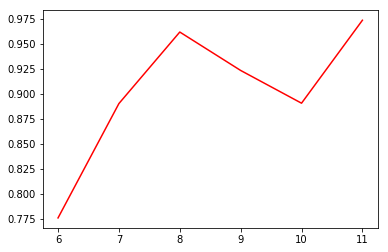

In [28]:
# plot the value
import matplotlib.pyplot as plt
plt.plot(para.month_test,strategy.loc[para.month_test,'value'],'r-') 
plt.show()


In [30]:
# evaluation
ann_excess_return = np.mean(strategy.loc[para.month_test,'return']) * 12
ann_excess_vol = np.std(strategy.loc[para.month_test,'return']) * np.sqrt(12)
info_ratio = ann_excess_return/ann_excess_vol
print('annual excess return = %.2f'%ann_excess_return) 
print('annual excess volatility = %.2f'%ann_excess_vol) 
print('information ratio = %.2f'%info_ratio)


annual excess return = 0.54
annual excess volatility = 0.24
information ratio = 2.30


E:\Anaconda3\lib\site-packages\pandas\core\indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]


In [ ]:
# save resulrs
import os
if not os.path.exists(para.path_results): 
    os.makedirs(para.path_results)
    filename = para.path_results + 'dataTestYhat.csv'
    y_score_test.to_csv(filename,header=0,index=False)
